# CReM tutorial

This tutorial will demonstrate some basic operations how to enumerate molecules based on a reference (parent) compound. There are three main functions which GROW, MUTATE or LINK molecules. We will look on them and some of their arguments. For full reference please visit documentation pages https://crem.readthedocs.io/en/latest/index.html

In [1]:
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,300)
IPythonConsole.ipython_useSVG=True

from crem.crem import mutate_mol, grow_mol, link_mols

RDKit WARNING: [14:37:37] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
# auxiliary functions to draw molecules with highlighting atoms 
def drawsvg(mol, highlightAtoms=[], highlightReplacement=False, molSize=(400, 300), kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        AllChem.Compute2DCoords(mc)
    if highlightReplacement:
        ids = []
        for a in mol.GetAtoms():
            if 'react_atom_idx' not in a.GetPropsAsDict():
                ids.append(a.GetIdx())
        if ids:
            highlightAtoms = ids
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc, highlightAtoms=highlightAtoms)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))


def drawgrid(mols, highlight=0):
    """
    highlight: 0 - no highlight
               1 - highlight changed atoms
               2 - highlight unchanged atoms
    """
    if highlight == 0:
        return Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(300,200), useSVG=True)
    else:
        ids_list = []
        for m in mols:
            ids = []
            for a in m.GetAtoms():
                if 'react_atom_idx' not in a.GetPropsAsDict():
                    ids.append(a.GetIdx())
            if highlight == 1:
                ids_list.append(ids)
            elif highlight == 2:
                ids_list.append(list(set(range(m.GetNumAtoms())) - set(ids)))
        return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,200), 
                                    highlightAtomLists=ids_list, useSVG=True)

To work with CReM you need a database of interchangeable fragments. This database can be prepared from the custom dataset of molecules. Alternatively you can use databases available at http://www.qsar4u.com/pages/crem.php which were prepared from ChMEBL compounds.

In [3]:
# specify the path to the fragmnet database
db_fname = 'replacements02_sc2.db'

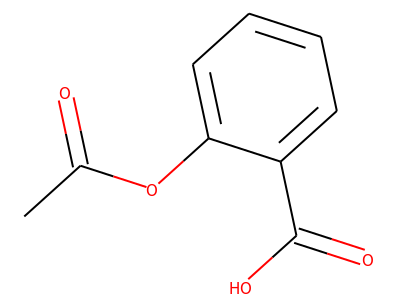

In [4]:
# take aspirin as an example parent molecule
mol = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
mol

## Grow

GROW is replacement of hydrogens with other fragments. Only one hydrogen is replaced at a time.

In [5]:
# let's grow the molecule
# we changed default values of one argument to receive RDKit Mol objects
mols = list(grow_mol(mol, db_fname, return_mol=True))
len(mols)

79

The function returns the list of smiles and mol objects. This might be not very convenient and we consider to change this behavior in future releases to return either smiles or molecules but not both.

In [6]:
mols[:4]

[['CC(=O)Oc1cccc(Br)c1C(=O)O', <rdkit.Chem.rdchem.Mol at 0x7f410c269450>],
 ['CC(=O)Oc1cccc(C)c1C(=O)O', <rdkit.Chem.rdchem.Mol at 0x7f40e1d01f50>],
 ['CC(=O)Oc1cccc(Cl)c1C(=O)O', <rdkit.Chem.rdchem.Mol at 0x7f40e1d01be0>],
 ['COc1cccc(OC(C)=O)c1C(=O)O', <rdkit.Chem.rdchem.Mol at 0x7f40e1d017c0>]]

We will remove hydrogen atoms which were added by the function and keep only Mol objects for further manipulations

In [7]:
mols = [Chem.RemoveHs(i[1]) for i in mols]
mols[:4]

There are three modes to visualize generated molecules. 0 - no highlighting, 1 - highligth changed atoms, 2 - highlight unchanged atoms

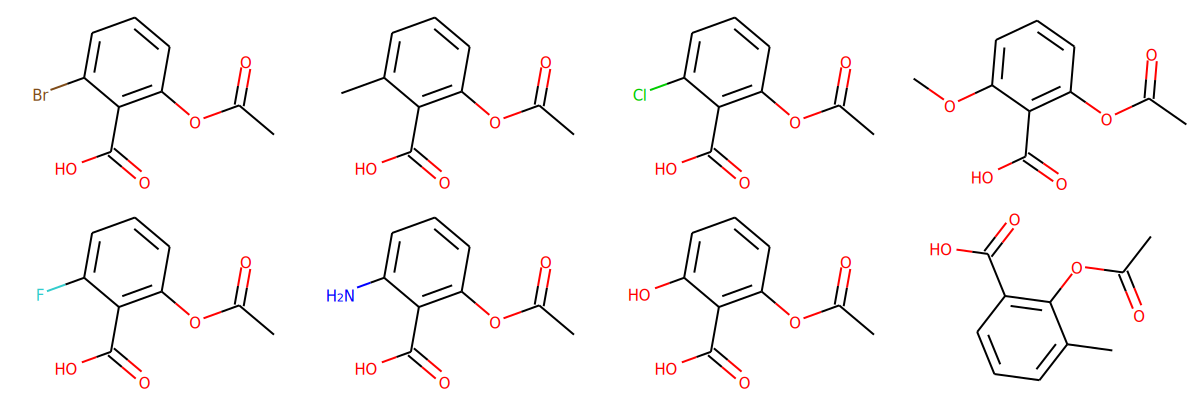

In [8]:
# depict molecules without highlighting
drawgrid(mols[:8], 0)

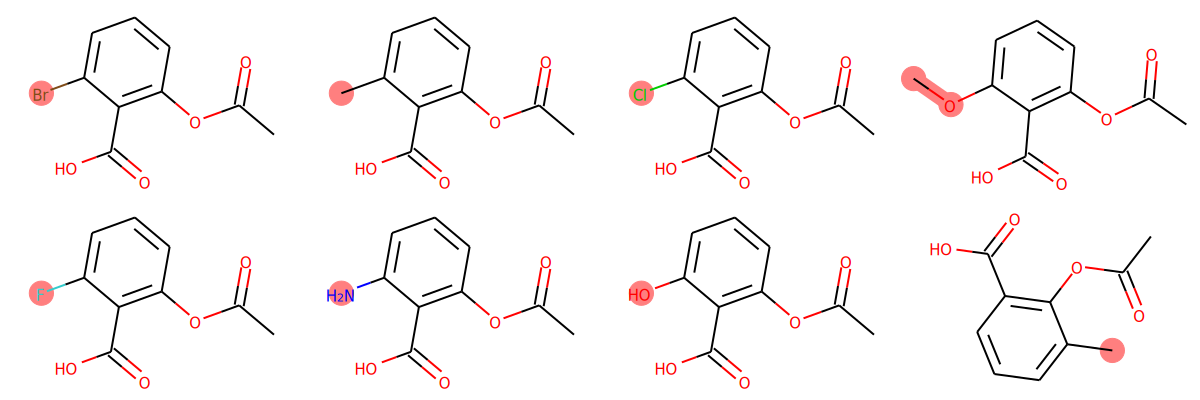

In [9]:
# depict molecules without highlighting of changed atoms
drawgrid(mols[:8], 1)

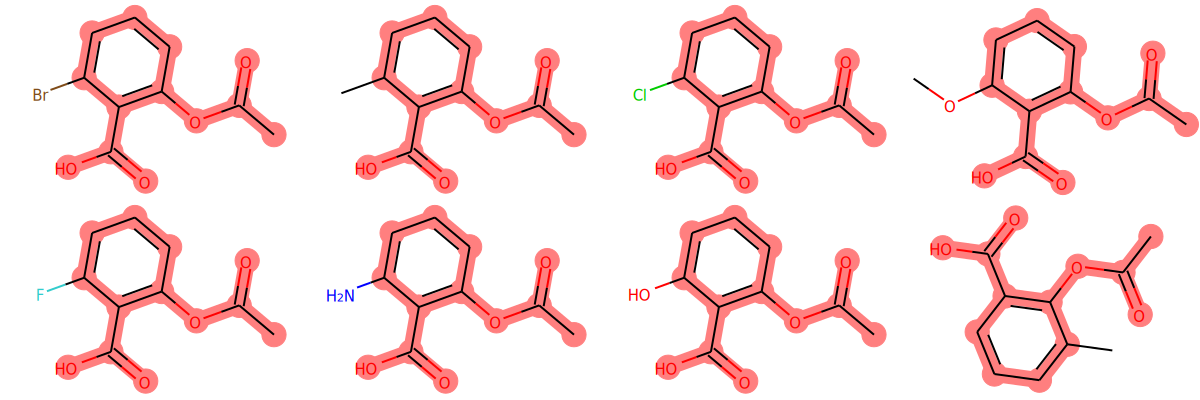

In [10]:
# depict molecules with highlighting of unchanged atoms
drawgrid(mols[:8], 2)

We used default arguments of the grow function. Therefore the structural changes are small, because by default the size of a replacing fragment is 1-2 heavy atoms.
Let's change the default parameters to replace hydrogens with larger fragments.

In [11]:
mols = list(grow_mol(mol, db_fname, return_mol=True, min_atoms=4, max_atoms=6))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

528

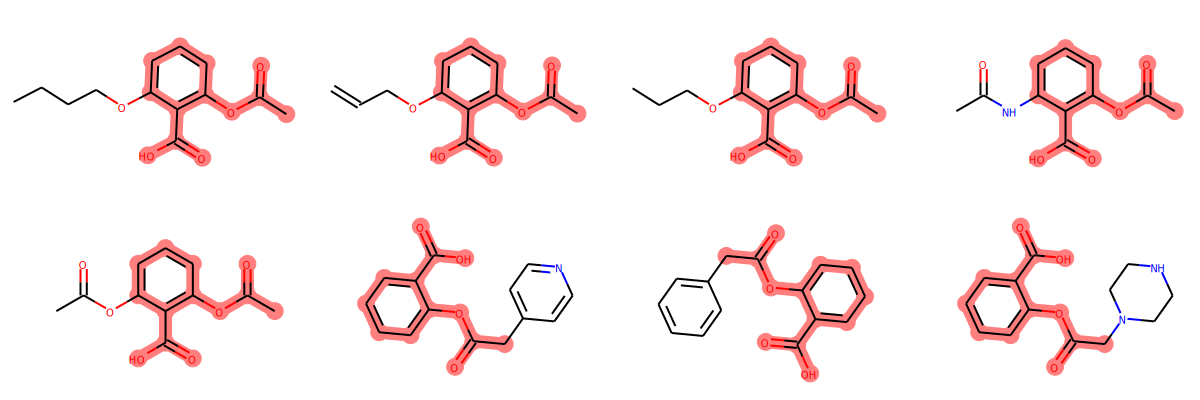

In [12]:
drawgrid(mols[:8], 2)

The user can also control the context radius which is considered for replacement. This is the important option because this determines how conservative replacements will be. The larger radius will produce more conservative replacements which will be less in number. Decreasing the radius may decrease synthetic feasibility and chemical rationality of generated structures. Therefore, for the whole tutorial we will use radius 3 (default) because at this radius the majority of functional groups are distinguishable.

In [13]:
# just for illustration change the radius to 1
mols = list(grow_mol(mol, db_fname, return_mol=True, radius=1))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

160

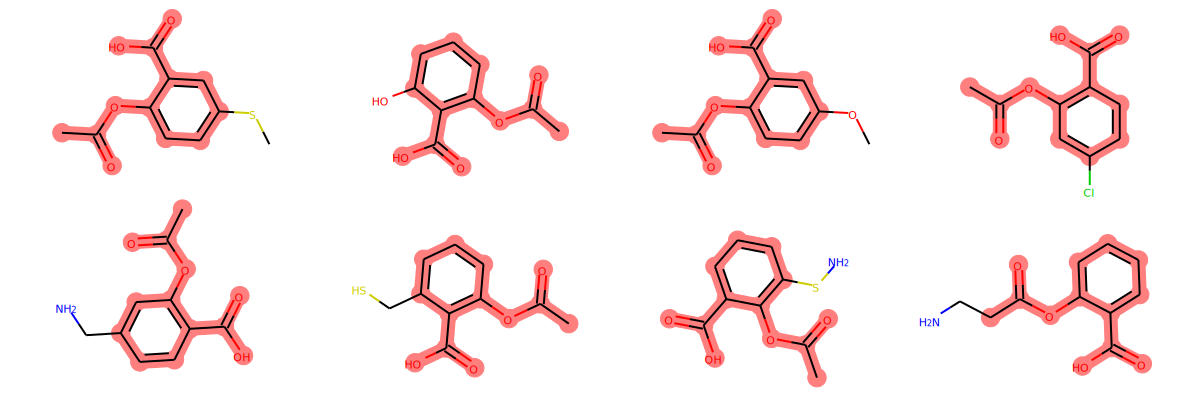

In [14]:
drawgrid(random.sample(mols, 8), 2)

The user can also control which atoms in a molecule can be changed. It is possible to specify either ids of atoms which should be protected from changes (e.g. scaffold, pharmacophores) or ids of atoms which should be replaced.
In the case if your parent molecule contains explicit hydrogens you can specify either ids of hydrogens or ids of heavy atoms whose hydrogen should be protected/replaced

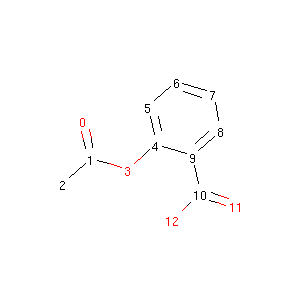

In [15]:
# let's depict atom ids of the aspirine molecule
Draw.MolToImage(mol, includeAtomNumbers=True, useSVG=True)

In [16]:
# let's generate molecules by growing only at atom 12 or 5
mols = list(grow_mol(mol, db_fname, return_mol=True, replace_ids=[5, 12]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

11

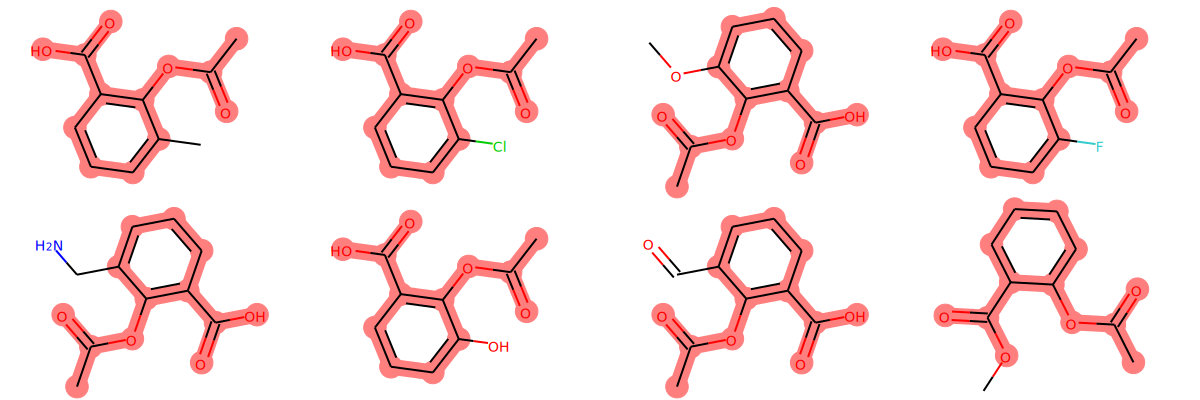

In [17]:
drawgrid(mols[:8], 2)

You may notice C(=O)OOH group appeared in one of generated molecules. This demonstrates that generated structures depends on the dataset used for fragmentation and database creation. More careful curation of the initial dataset can reduce amount of unfeasible/undesired output structures.

## Mutate

MUTATE is a more general operation that GROW. This replaces any fragments not only hydrogens with any fragments. Thus, it can be used to replace hydrogens with heavy atom fragments (like GROW) or heavy atom fragments with hydrogens or heavy atom fragments with other heavy atom fragments. Below we will demonstrate how to control this.

In [18]:
# default mutation of aspirine
mols = list(mutate_mol(mol, db_fname, return_mol=True))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

1995

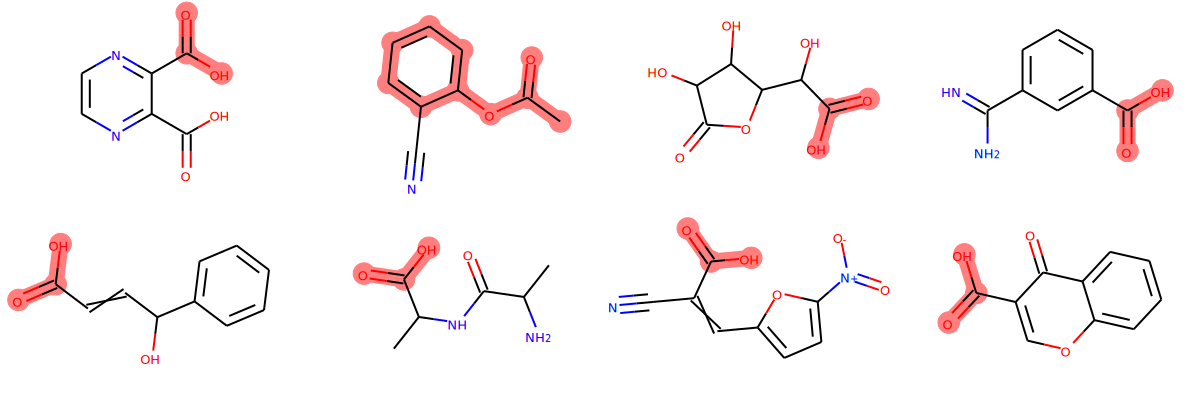

In [19]:
drawgrid(random.sample(mols, 8), 2)

You see large changes in the structure. This was happened due to default arguments. By default the size of replaced fragmnets is from 0 to 10 heavy atoms. 0 means hydrogens, but unless molecule have explicit hydrogens they will not be replaced.

In [20]:
# replace only fragments having 1 heavy atom.
mols = list(mutate_mol(mol, db_fname, return_mol=True, min_size=1, max_size=1))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

45

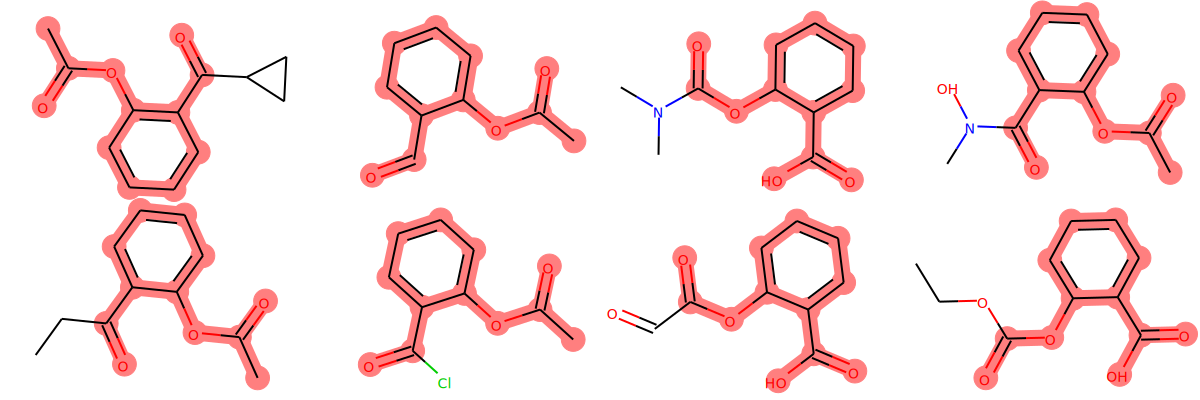

In [21]:
drawgrid(random.sample(mols, 8), 2)

The size of replacing fragments is determined relatively to the size of a replaced fragment. There are two arguments: min_inc(rement) and max_inc(rement). If the size of a replaced fragment is N, the the size of replacing fragments will be from N + min_inc to N + max_inc.

In [22]:
mols = list(mutate_mol(mol, db_fname, return_mol=True, min_size=1, max_size=2, min_inc=-1, max_inc=1))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

35

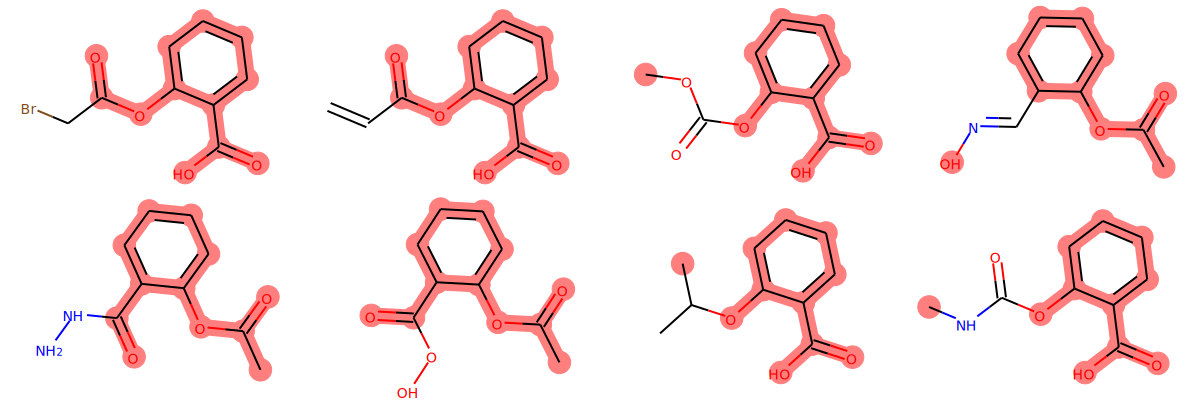

In [23]:
drawgrid(random.sample(mols, 8), 2)

Using negative increments you can remove particular fragments (replace them with hydrogens)

In [24]:
mols = list(mutate_mol(mol, db_fname, return_mol=True, min_size=1, max_size=1, min_inc=-1, max_inc=-1))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

2

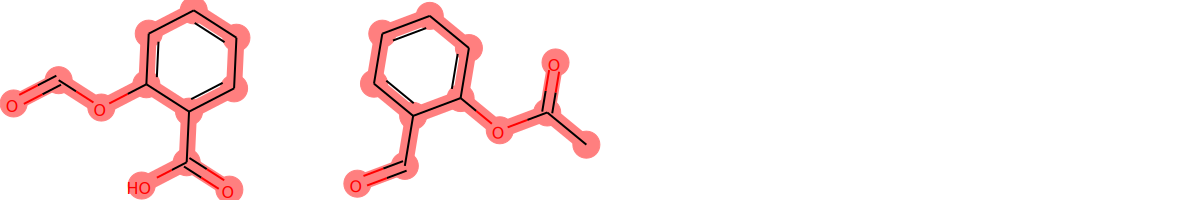

In [25]:
drawgrid(mols[:8], 2)

Or you can replace fragments only with larger ones

In [26]:
mols = list(mutate_mol(mol, db_fname, return_mol=True, min_size=1, max_size=1, min_inc=1, max_inc=2))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

38

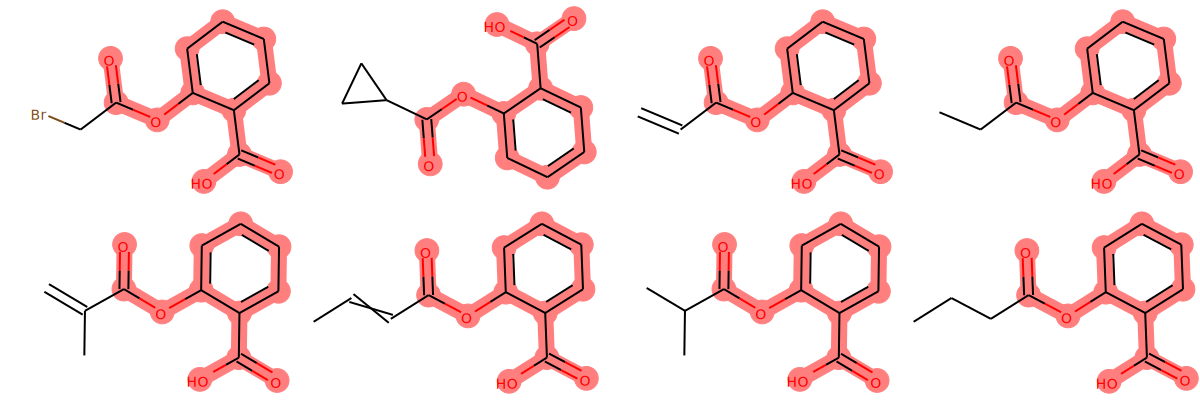

In [27]:
drawgrid(mols[:8], 2)

As it was mentioned above, if the user provide a molecules with explicit hydrogens these hydrogens can be replaced like in the grow function but min_size should be set to 0. The call below will result in identical output to the grow function. Actually grow is a convenience wrapper over the mutate function.

In [28]:
mols = list(mutate_mol(Chem.AddHs(mol), db_fname, return_mol=True, min_size=0, max_size=0, min_inc=1, max_inc=2))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

79

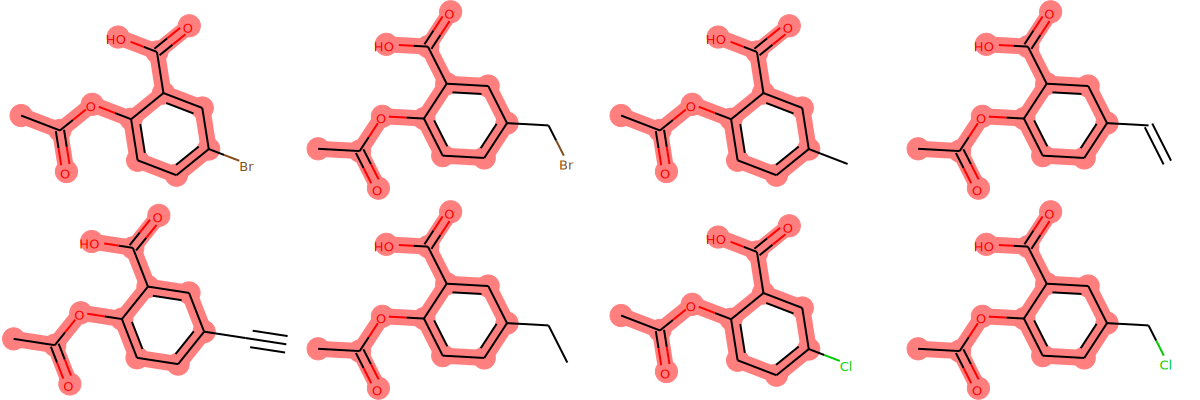

In [29]:
drawgrid(mols[:8], 2)

The user can protect particular atoms from changes or replace particular atoms.

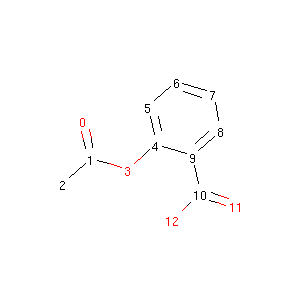

In [30]:
Draw.MolToImage(mol, includeAtomNumbers=True, useSVG=True)

In [31]:
# protect acetyl from changes (atom ids 0, 1 ,2, 3)
mols = list(mutate_mol(mol, db_fname, return_mol=True, protected_ids=[0, 1, 3]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

216

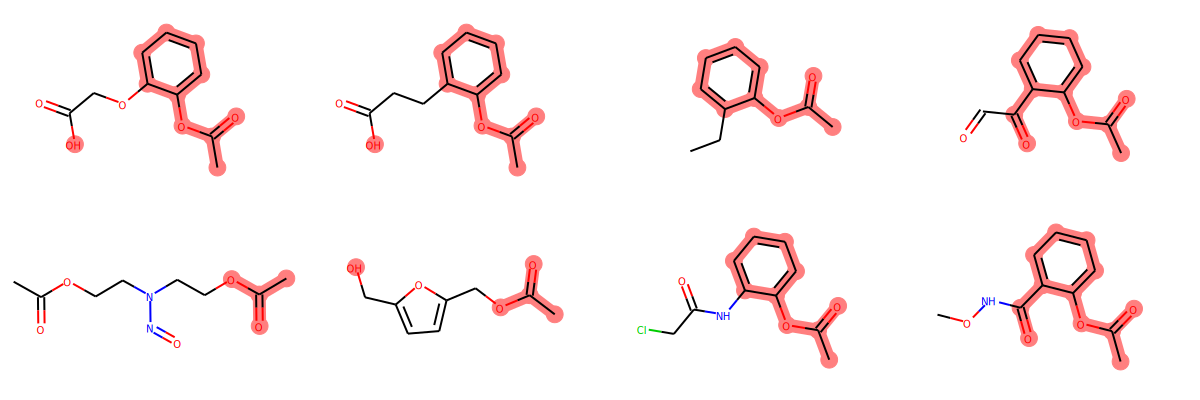

In [32]:
drawgrid(random.sample(mols, 8), 2)

In [33]:
# replace ester group C(=O)O with atom ids 0, 1 and 3
mols = list(mutate_mol(Chem.AddHs(mol), db_fname, return_mol=True, replace_ids=[0, 1, 3]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

38

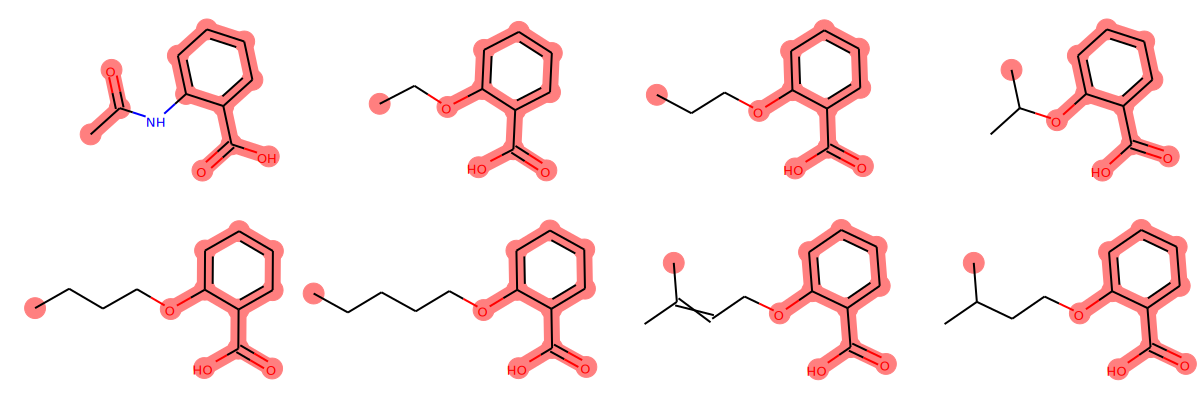

In [34]:
drawgrid(mols[:8], 2)

In [35]:
# if you will specify to replace fragments with at most 2 atoms then the whole ester group will not be replaced, but oxygen and carbonyl will be repalced
mols = list(mutate_mol(Chem.AddHs(mol), db_fname, return_mol=True, min_size=0, max_size=2, replace_ids=[0, 1, 3]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

20

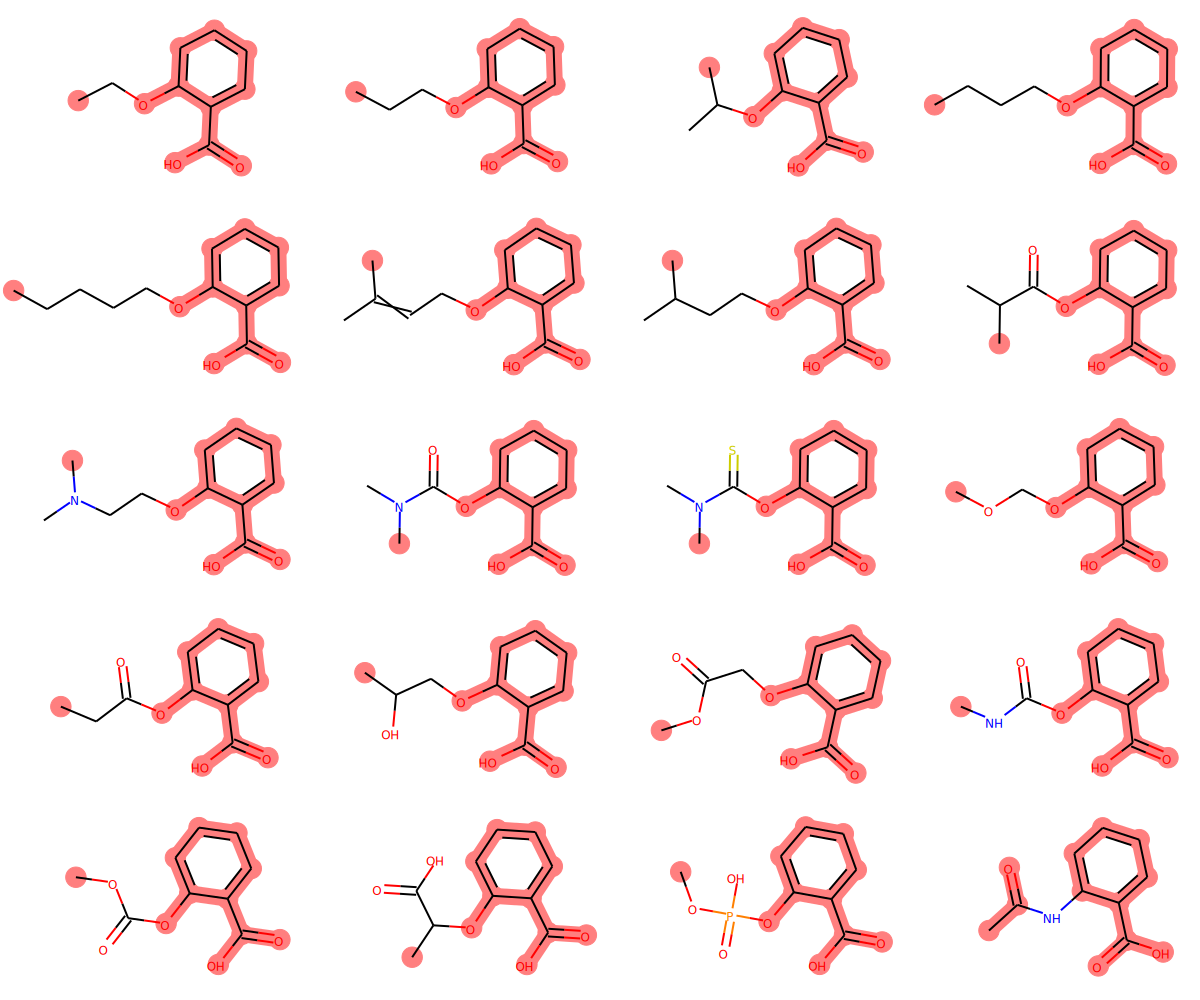

In [36]:
drawgrid(mols, 2)

## Link

LINK replaces hydrogens at two molecules with the linker fragment from the database.

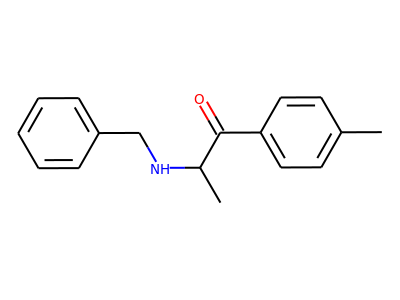

In [37]:
# benzedrone
mol2 = Chem.MolFromSmiles('c2ccccc2CNC(C)C(=O)c(cc1)ccc1C')
mol2

In [38]:
mols = list(link_mols(mol, mol2, db_fname, return_mol=True))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

111

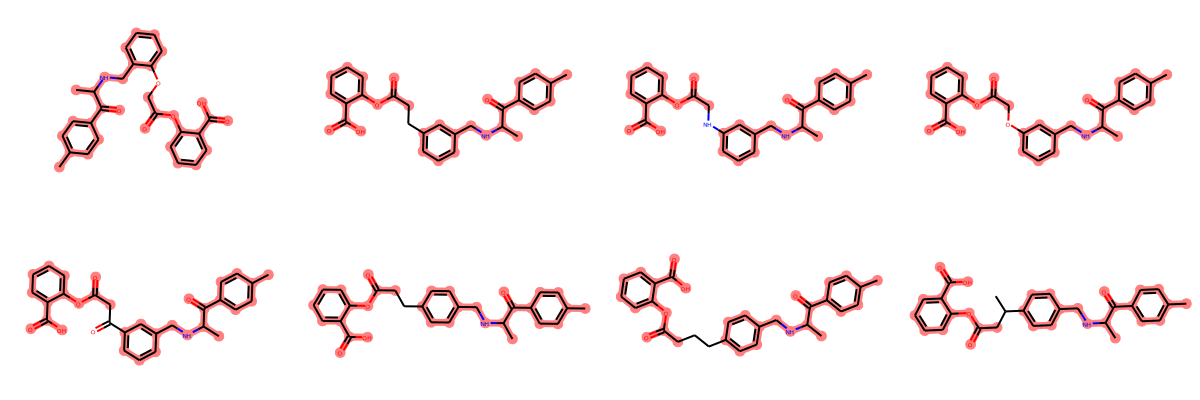

In [39]:
drawgrid(mols[:8], 2)

It is also possible to specify the size of a linker and particular atoms which should be protected or linked.

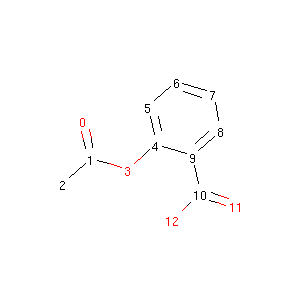

In [40]:
Draw.MolToImage(mol, includeAtomNumbers=True, useSVG=True)

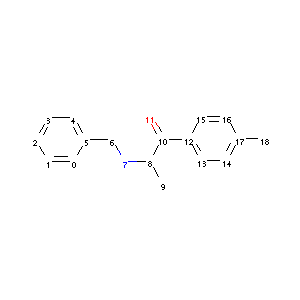

In [41]:
Draw.MolToImage(mol2, includeAtomNumbers=True, useSVG=True)

In [42]:
# let's link atom 12 of aspirin with atom 2 of benzedrone
mols = list(link_mols(mol, mol2, db_fname, return_mol=True, min_atoms=1, max_atoms=6, replace_ids_1=[12], replace_ids_2=[2]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

21

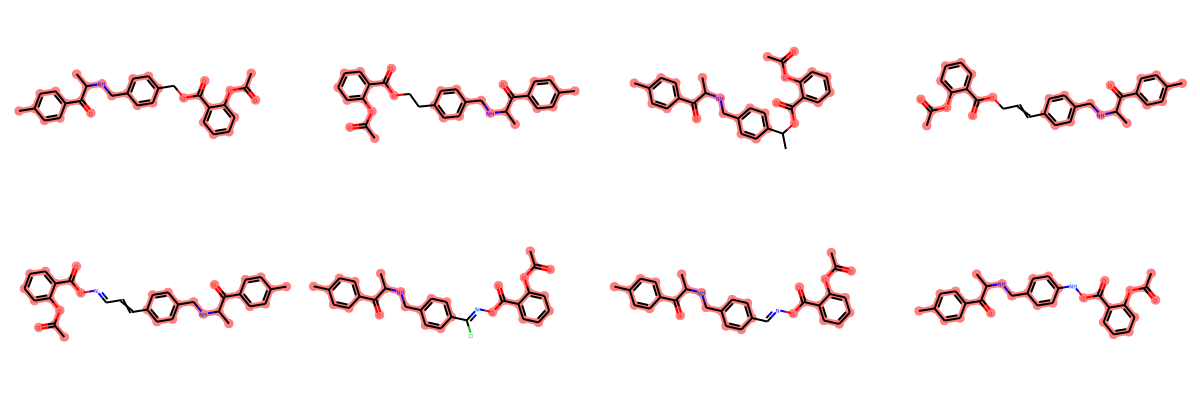

In [43]:
drawgrid(mols[:8], 2)

To control the distance between linked molecules the user can provide the value of the dist argument which is a number of bonds between connected molecules in a generate structure.

In [44]:
# link molecules by fragments which separate them by exactly two bonds
mols = list(link_mols(mol, mol2, db_fname, return_mol=True, min_atoms=1, max_atoms=6, dist=2))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

81

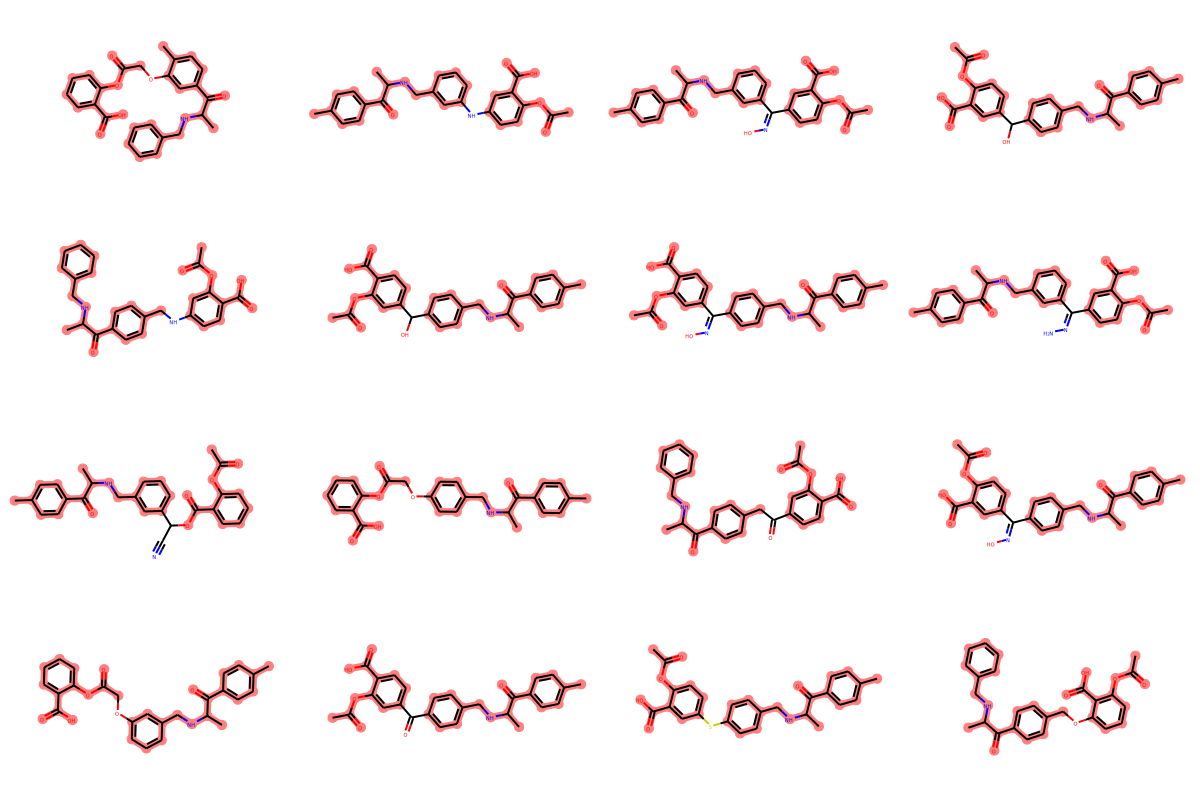

In [45]:
drawgrid(random.sample(mols, 16), 2)

In [46]:
# dist argument can be a tuple of lower and upper distance values
mols = list(link_mols(mol, mol2, db_fname, return_mol=True, min_atoms=1, max_atoms=6, dist=(2, 3)))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

270

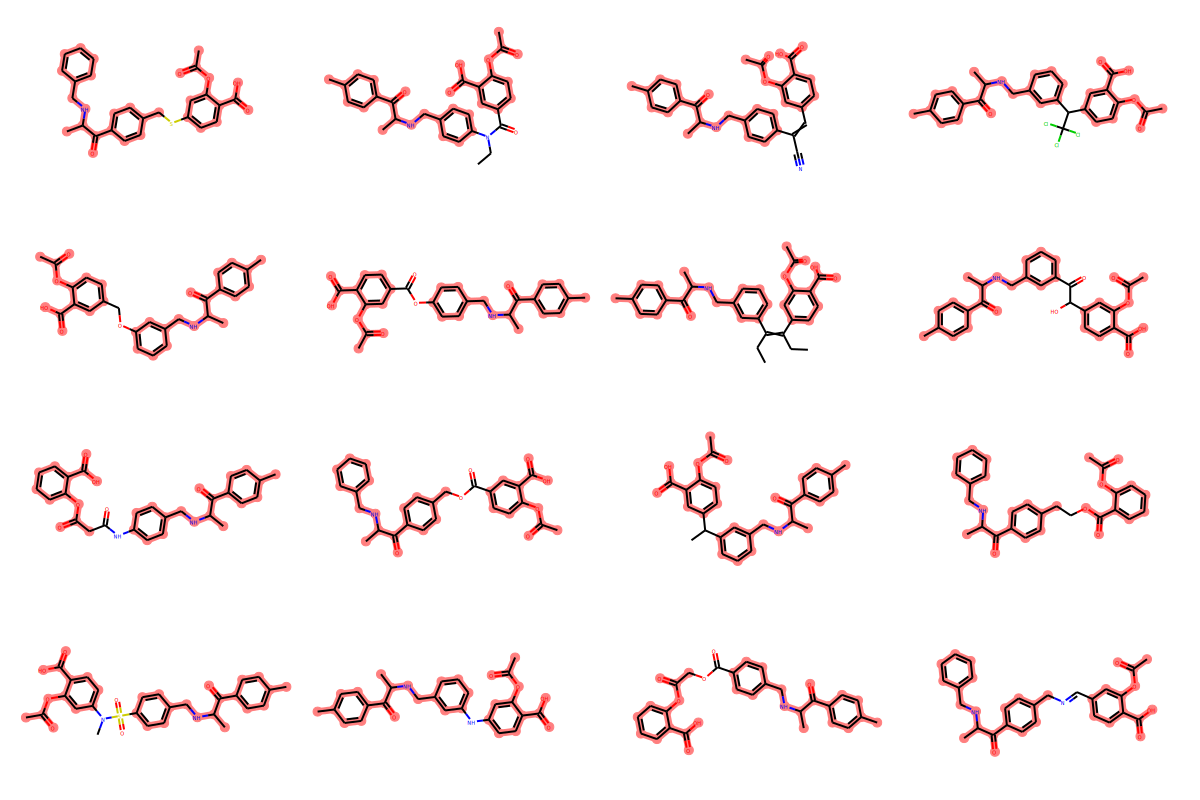

In [47]:
drawgrid(random.sample(mols, 16), 2)